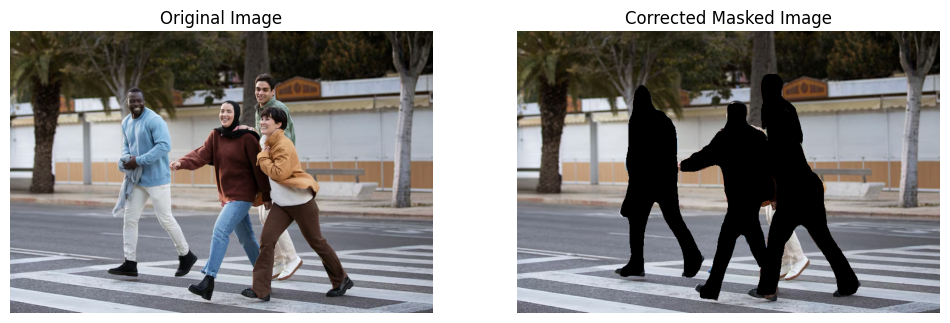

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def mask_people_in_image(image_path, confidence_threshold=0.75):
    """
    Loads an image, runs a pre-trained Mask R-CNN to find people,
    and returns the original image with all detected people masked out (turned black).
    """
    # Step 1: Load the pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.eval()

    # Step 2: Load and pre-process the image
    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img_pil)

    # Step 3: Run inference
    with torch.no_grad():
        prediction = model([img_tensor])

    # Step 4: Create a combined mask for all detected people
    img_np = np.array(img_pil) # Original image in RGB as a NumPy array
    combined_mask = np.zeros(img_np.shape[:2], dtype="uint8")

    for i in range(len(prediction[0]['labels'])):
        label_id = prediction[0]['labels'][i].item()
        score = prediction[0]['scores'][i].item()

        # Check if the detected object is a 'person' and has high confidence
        if label_id == 1 and score > confidence_threshold:
            # Get the mask for this person, which is a tensor of values from 0.0 to 1.0
            person_mask = prediction[0]['masks'][i, 0].cpu().numpy()

            # Create a binary mask (0 or 255) by thresholding
            binary_mask = (person_mask > 0.5).astype(np.uint8) * 255

            # Add this person's mask to our combined mask
            combined_mask = cv2.bitwise_or(combined_mask, binary_mask)

    # --- THIS IS THE CORRECTED LOGIC ---
    # Step 5: Apply the mask to make the person areas black
    # The 'where' argument of np.copyto does this efficiently:
    # where the mask is 255 (person), copy from a black pixel (0). Otherwise, keep the original.
    masked_image = img_np.copy()
    masked_image[combined_mask == 255] = 0 # Set pixels to black where the mask is white

    return masked_image, img_np

# --- Example Usage ---
# Make sure your uploaded image is named 'image_20a908.jpg' in the Colab file browser
try:
    masked_img, original_img = mask_people_in_image('test_image.jpg')

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(masked_img)
    plt.title("Corrected Masked Image")
    plt.axis("off")
    plt.show()

except FileNotFoundError:
    print("Please make sure your uploaded image is named 'image_20a908.jpg' and run this cell again.")

In [1]:
import os
from google.colab import files
import kagglehub

# --- Step 1: Install KaggleHub ---
!pip install -q kagglehub

# --- Step 2: Configure Kaggle API Key ---
# This part only runs if the API key isn't already set up.
# This makes the cell re-runnable without uploading the key every time.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your 'kaggle.json' file:")
    try:
        # Prompt user to upload the file
        uploaded = files.upload()

        # Check if the file was uploaded
        if 'kaggle.json' not in uploaded:
            print("\n❌ ERROR: 'kaggle.json' not found. Please upload the correct file.")
        else:
            # Set up the directory and permissions
            !mkdir -p ~/.kaggle
            !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            print("\n✅ Kaggle API configured successfully.")

    except Exception as e:
        print(f"\nAn error occurred during file upload: {e}")
else:
    print("✅ Kaggle API is already configured.")


# --- Step 3: Download and Unzip the Dataset using KaggleHub ---
print("\nDownloading and extracting the dataset...")
try:
    # Use the URL slug 'person-segmentation' which works with kagglehub
    dataset_slug = "nikhilroxtomar/person-segmentation"

    # kagglehub.dataset_download automatically downloads and unzips the data
    path = kagglehub.dataset_download(dataset_slug)

    print(f"\n🎉 Success! Dataset downloaded and extracted to:")
    print(path)

    # --- Step 4 (Bonus): Verify the contents ---
    print("\nVerifying extracted contents:")
    # The 'tree' command provides a nice visual of the directory structure
    !sudo apt-get -qq install tree
    !tree -L 2 {path}

except Exception as e:
    print(f"\n❌ An error occurred during download: {e}")
    print("Please ensure you have accepted the dataset's rules on the Kaggle website.")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json

✅ Kaggle API configured successfully.



100%|██████████| 461M/461M [00:23<00:00, 21.0MB/s]

Extracting files...



🎉 Success! Dataset downloaded and extracted to:
/root/.cache/kagglehub/datasets/nikhilroxtomar/person-segmentation/versions/1

Verifying extracted contents:
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/root/.cache/kagglehub/datasets/nikhilroxtomar/person-segmentation/versions/1
└── people_segmentation
    ├── images
 

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# The path points to the directory containing the 'images' and 'masks' folders
# kagglehub automatically provides this path
BASE_PATH = "/root/.cache/kagglehub/datasets/nikhilroxtomar/person-segmentation/versions/1/people_segmentation/"

IMAGE_DIR = os.path.join(BASE_PATH, "images")
MASK_DIR = os.path.join(BASE_PATH, "masks")

# --- Custom Dataset Class ---
class HumanSegmentationDataset(Dataset):
    """
    Custom PyTorch Dataset for the Human Segmentation dataset.
    """
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Get a sorted list of image files to ensure alignment with masks
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Get the image file name
        img_name = self.image_files[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Construct the corresponding mask file name
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image and mask using PIL
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # 'L' mode for grayscale

        return image, mask

print("✅ Dataset class defined and paths are set.")

✅ Dataset class defined and paths are set.


In [6]:
import torchvision
from torchvision.transforms import functional as F
from tqdm import tqdm

# --- Helper function to calculate Intersection over Union (IoU) ---
def calculate_iou(pred_mask, gt_mask):
    """
    Calculates the IoU score between two binary masks.
    Masks are expected to be NumPy arrays with values 0 or 1.
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 # If both masks are empty, it's a perfect match

    iou_score = intersection / union
    return iou_score

# --- Main Benchmarking Function ---
def benchmark_model(confidence_threshold=0.1): # Keep the low threshold
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running benchmark on device: {device}")

    # 1. Load the pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(device)
    model.eval()

    # 2. Create the dataset
    dataset = HumanSegmentationDataset(image_dir=IMAGE_DIR, mask_dir=MASK_DIR)

    # 3. Loop through dataset and evaluate
    iou_scores = []

    for i in tqdm(range(len(dataset)), desc="Benchmarking Progress"):
        original_image, gt_mask_pil = dataset[i]

        # Prepare image for the model
        img_tensor = F.to_tensor(original_image).to(device)

        # Run inference
        with torch.no_grad():
            prediction = model([img_tensor])

        # --- Process Prediction to create a single binary mask ---
        pred_mask_combined = np.zeros((original_image.height, original_image.width), dtype=np.uint8)

        for j in range(len(prediction[0]['labels'])):
            label_id = prediction[0]['labels'][j].item()
            score = prediction[0]['scores'][j].item()

            if label_id == 1 and score > confidence_threshold: # label 1 is 'person'
                person_mask = prediction[0]['masks'][j, 0].cpu().numpy()
                binary_mask = (person_mask > 0.5).astype(np.uint8)
                pred_mask_combined = np.logical_or(pred_mask_combined, binary_mask)

        # --- Process Ground Truth Mask ---
        gt_mask_np = np.array(gt_mask_pil)

        # ----- THIS IS THE FIX! -----
        # Use > 0 to be robust to masks that use 1 or 255 for the person.
        gt_mask_binary = (gt_mask_np > 0).astype(np.uint8)

        # --- Calculate IoU for this image ---
        iou = calculate_iou(pred_mask_combined.astype(np.uint8), gt_mask_binary)
        iou_scores.append(iou)

    # --- Calculate and print the final Mean IoU ---
    mIoU = np.mean(iou_scores)
    print("\n--- BENCHMARK COMPLETE ---")
    print(f"✅ Mean Intersection over Union (mIoU): {mIoU:.4f}")
    return mIoU

# Run the benchmark
mean_iou_score = benchmark_model()

Running benchmark on device: cuda


Benchmarking Progress: 100%|██████████| 5678/5678 [13:58<00:00,  6.77it/s]


--- BENCHMARK COMPLETE ---
✅ Mean Intersection over Union (mIoU): 0.8516



--- Visualizing Random Predictions ---


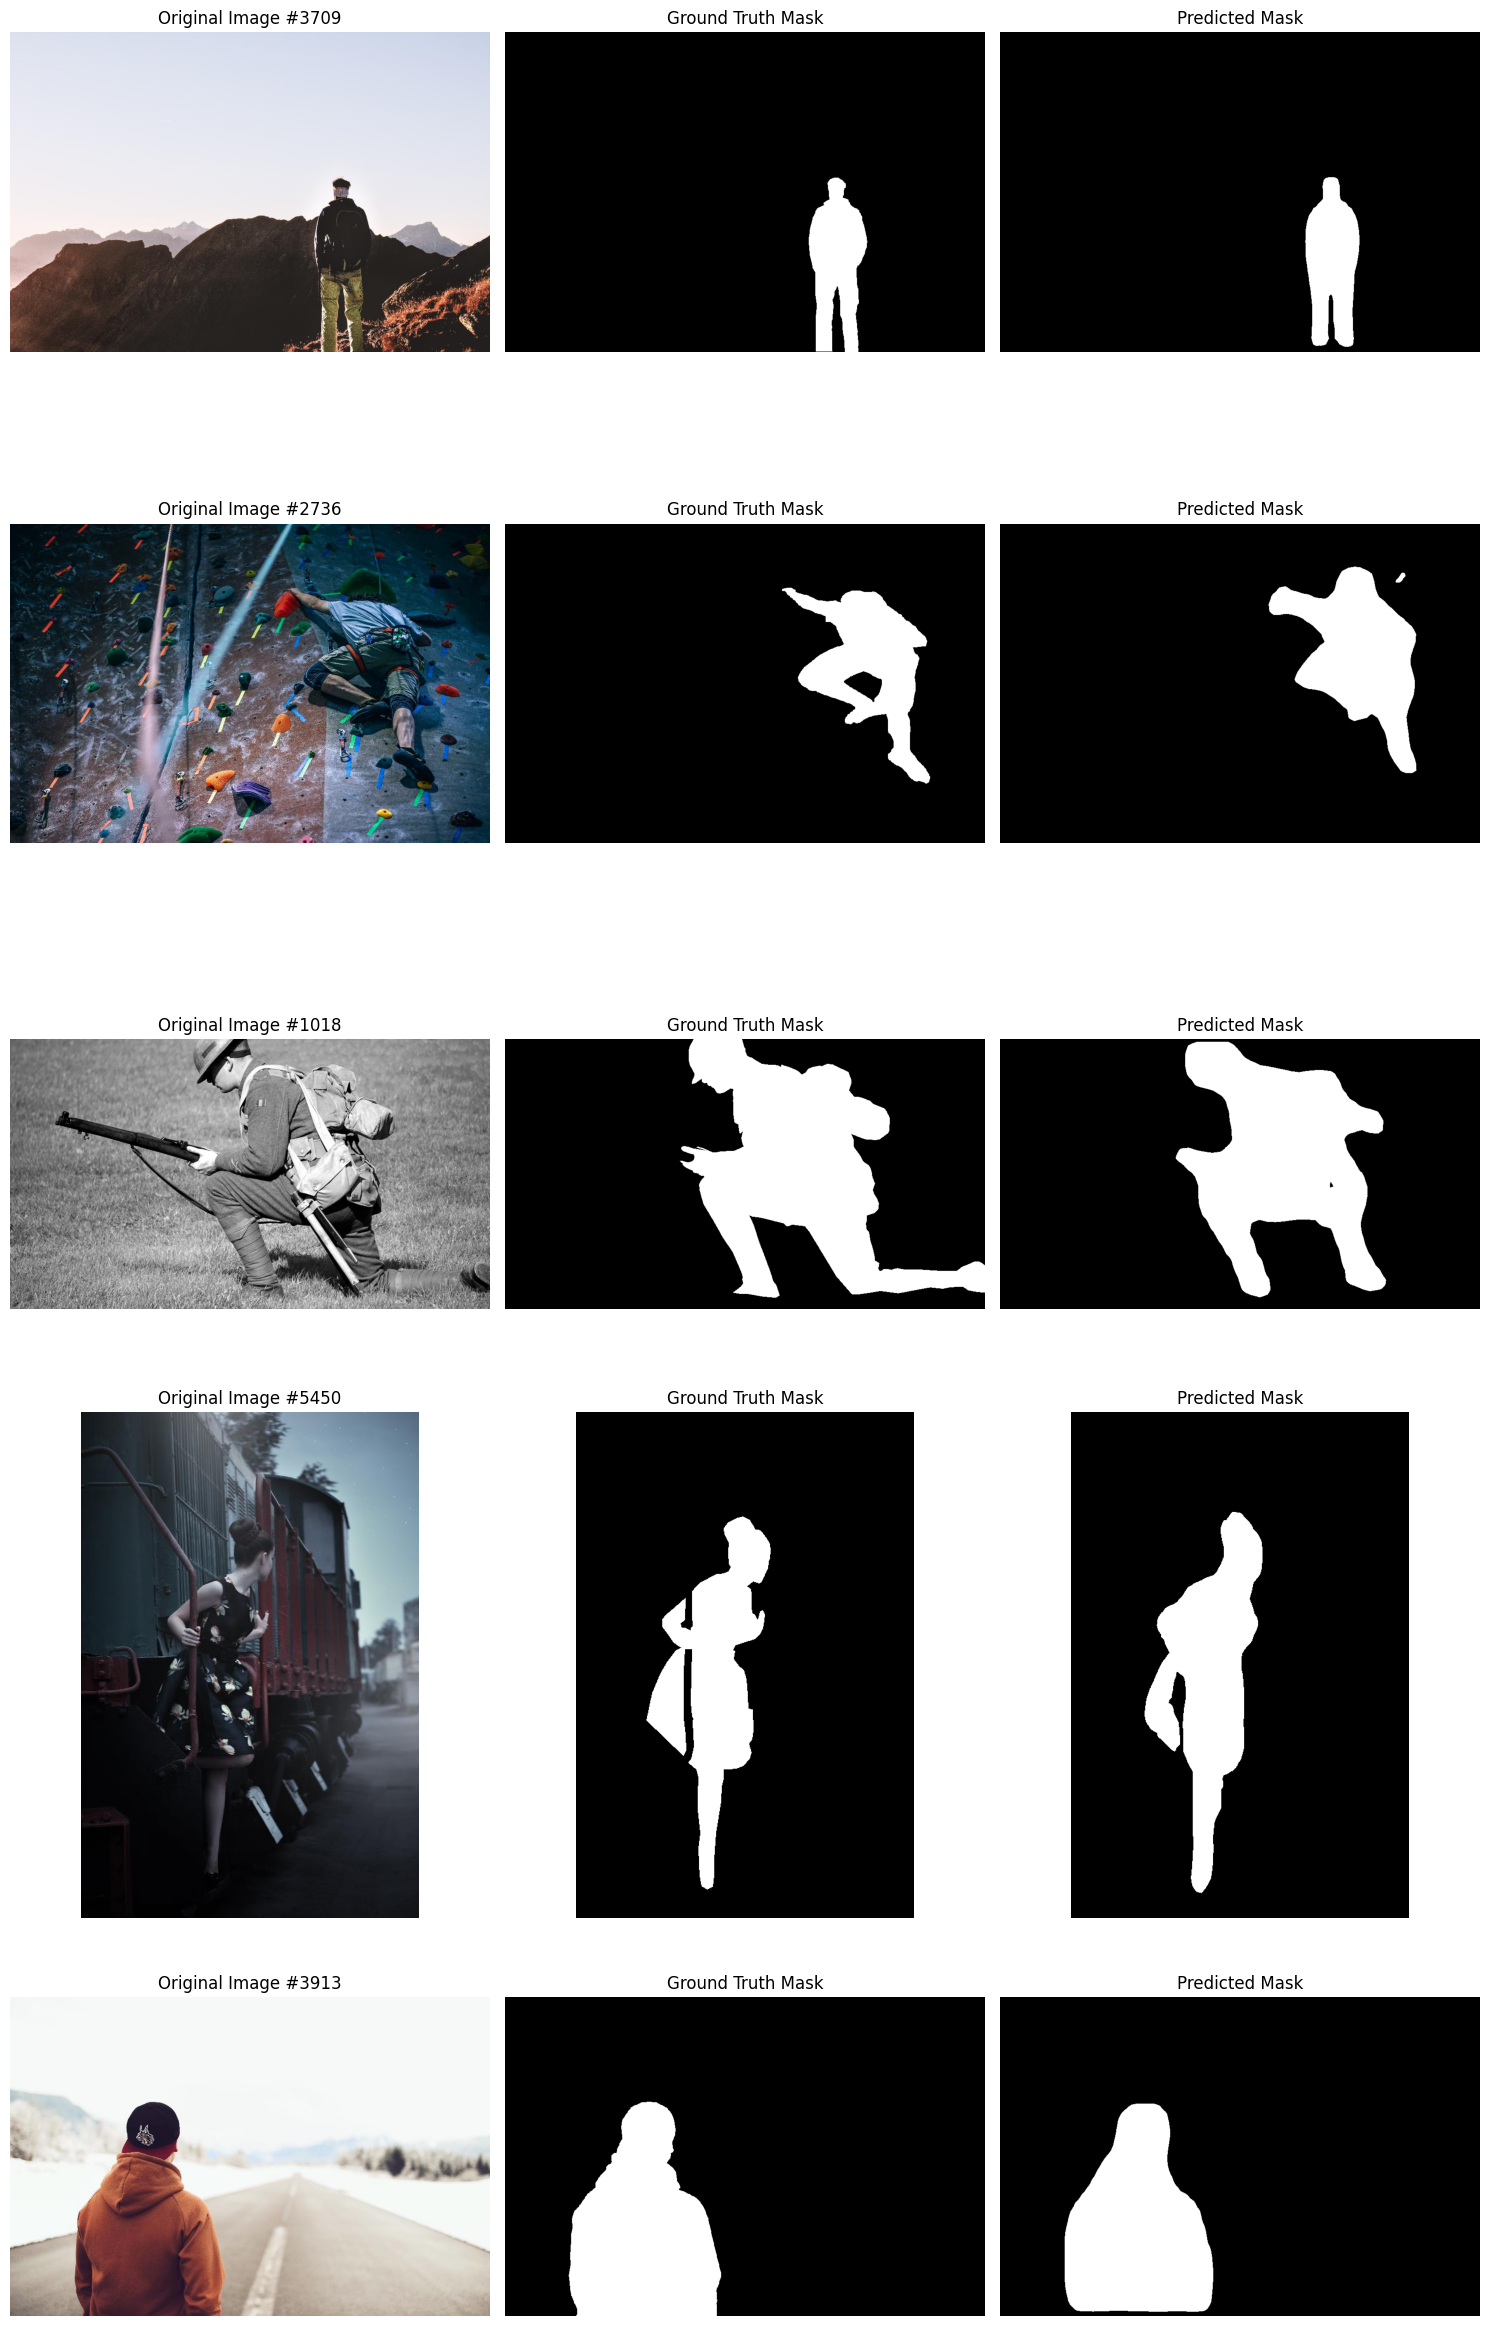

In [7]:
import random

def visualize_results(num_images=5):
    print("\n--- Visualizing Random Predictions ---")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(device)
    model.eval()

    dataset = HumanSegmentationDataset(image_dir=IMAGE_DIR, mask_dir=MASK_DIR)

    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, gt_mask = dataset[idx]

        # Generate prediction
        img_tensor = F.to_tensor(image).to(device)
        with torch.no_grad():
            prediction = model([img_tensor])

        # Process prediction to get a binary mask
        pred_mask_combined = np.zeros((image.height, image.width), dtype=np.uint8)
        for j in range(len(prediction[0]['labels'])):
            if prediction[0]['labels'][j] == 1 and prediction[0]['scores'][j] > 0.5:
                person_mask = (prediction[0]['masks'][j, 0].cpu().numpy() > 0.5).astype(np.uint8)
                pred_mask_combined = np.logical_or(pred_mask_combined, person_mask)

        # Plotting
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"Original Image #{idx}")
        plt.axis("off")

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(pred_mask_combined, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_results()

In [8]:
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from google.colab import files

def process_video(input_path, output_path, confidence_threshold=0.5):
    """
    Reads a video, applies person masking to each frame, and saves the output.
    """
    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load the pre-trained Mask R-CNN model once
    print("Loading Mask R-CNN model...")
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(device)
    model.eval()
    print("✅ Model loaded.")

    # 2. Set up video reader (capture)
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video file at {input_path}")
        return

    # Get video properties for the writer
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # 3. Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    print(f"\nProcessing video: {total_frames} frames at {fps} FPS...")

    # --- Processing Loop ---
    for _ in tqdm(range(total_frames), desc="Processing Frames"):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame from OpenCV's BGR to RGB for PIL/PyTorch
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Prepare image for the model
        img_tensor = F.to_tensor(rgb_frame).to(device)

        # Run inference
        with torch.no_grad():
            prediction = model([img_tensor])

        # Create a combined mask for all detected people
        combined_mask = np.zeros((frame_height, frame_width), dtype="uint8")
        for i in range(len(prediction[0]['labels'])):
            label_id = prediction[0]['labels'][i].item()
            score = prediction[0]['scores'][i].item()

            if label_id == 1 and score > confidence_threshold: # label 1 is 'person'
                person_mask = (prediction[0]['masks'][i, 0].cpu().numpy() > 0.5).astype(np.uint8) * 255
                combined_mask = cv2.bitwise_or(combined_mask, person_mask)

        # Apply the mask to the original BGR frame
        frame[combined_mask == 255] = 0

        # Write the processed frame to the output video
        out.write(frame)

    # --- Cleanup ---
    cap.release()
    out.release()
    print(f"\n🎉 Success! Processed video saved to: {output_path}")

# --- MAIN EXECUTION BLOCK ---

# 1. Prompt the user to upload a video file
print("Please upload your video file...")
uploaded = files.upload()

# Check if a file was uploaded
if len(uploaded) == 0:
    print("\n❌ No file uploaded. Please run the cell again.")
else:
    # Get the name of the uploaded file (it's the first key in the dictionary)
    input_video_file = list(uploaded.keys())[0]
    output_video_file = 'masked_' + input_video_file

    print(f"\n✅ File '{input_video_file}' uploaded successfully.")

    try:
        # 2. Call the processing function with the uploaded file
        process_video(input_video_file, output_video_file, confidence_threshold=0.5)

    except Exception as e:
        print(f"An error occurred: {e}")

Please upload your video file...


Saving mask_testing.mp4 to mask_testing.mp4

✅ File 'mask_testing.mp4' uploaded successfully.
Using device: cuda
Loading Mask R-CNN model...
✅ Model loaded.

Processing video: 174 frames at 30 FPS...


Processing Frames: 100%|██████████| 174/174 [00:28<00:00,  6.05it/s]


🎉 Success! Processed video saved to: masked_mask_testing.mp4


--- Step 1: Installing necessary libraries ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 92.1 MB/s eta 0:00:00
--- Step 1: Environment setup complete ---

--- Step 2: Defining the person-masking function ---

--- Step 3: Defining the Visual Odometry function ---

--- Step 4: Starting the Benchmark ---
Please upload your video file (.mp4, .mov, etc.)


Saving testing2.mp4 to testing2.mp4

Video 'testing2.mp4' uploaded successfully.

Initializing AI models on device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:03<00:00, 12.1MB/s]

✅ All models loaded.

Running odometry on: testing2.mp4


Processing Odometry:   0%|          | 0/338 [00:00<?, ?it/s]


Creating masked video on device: cuda


Creating Masked Video:   0%|          | 0/339 [00:00<?, ?it/s]

✅ Masked video saved to: masked_testing2.mp4

Running odometry on: masked_testing2.mp4


Processing Odometry:   0%|          | 0/338 [00:00<?, ?it/s]



--- Step 5: Benchmark Results and Assessment ---


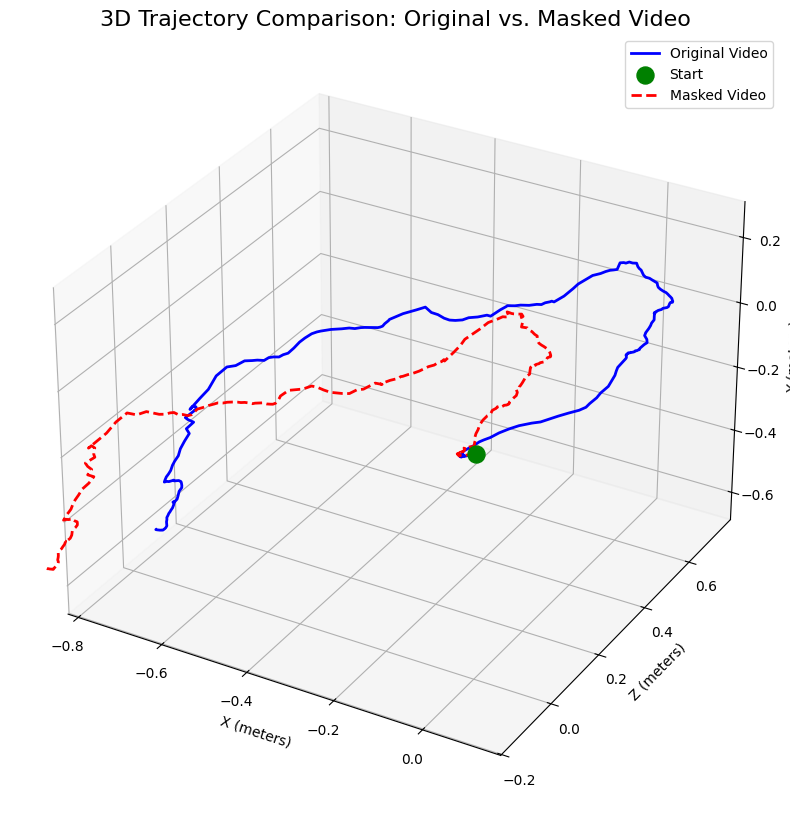


## 📈 Assessment of Results

The 3D plot above provides a clear comparison between the two odometry runs. The **blue line** represents the trajectory calculated from the original video, while the **red dashed line** shows the trajectory from the video with people masked out.

**Hypothesis:** The masked video should produce a more stable and accurate trajectory, especially if your video contains significant human motion.

**Why?**
Visual odometry algorithms like this one rely on the **static world assumption**—they assume that all points in the scene are stationary. When a feature tracker (like LoFTR) locks onto a person who is walking, it breaks this assumption. The algorithm incorrectly interprets the person's motion as the camera's motion, leading to errors in the pose estimation. These small errors accumulate over time, causing the trajectory to **'drift'** away from the true path.

**Interpreting Your Plot:**
* If the **red line is smoother** and follows a more logical path than th

In [9]:
# ==============================================================================
# STEP 1: SETUP, IMPORTS, AND AUTHENTICATION
# ==============================================================================
print("--- Step 1: Installing necessary libraries ---")
!pip install -q kornia kornia_rs opencv-python matplotlib tqdm transformers

import os
import numpy as np
import torch
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from google.colab import files
import torchvision
from torchvision.transforms import functional as F

print("--- Step 1: Environment setup complete ---")

# ==============================================================================
# STEP 2: DEFINE THE MASK R-CNN VIDEO PROCESSING FUNCTION
# ==============================================================================
print("\n--- Step 2: Defining the person-masking function ---")

def create_masked_video(input_path, output_path, confidence_threshold=0.5):
    """
    Reads a video, applies person masking using Mask R-CNN to each frame,
    and saves the output to a new video file.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nCreating masked video on device: {device}")

    # Load the pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(device)
    model.eval()

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video file at {input_path}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    for _ in tqdm(range(total_frames), desc="Creating Masked Video"):
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = F.to_tensor(rgb_frame).to(device)

        with torch.no_grad():
            prediction = model([img_tensor])

        combined_mask = np.zeros((frame_height, frame_width), dtype="uint8")
        for i in range(len(prediction[0]['labels'])):
            if prediction[0]['labels'][i] == 1 and prediction[0]['scores'][i] > confidence_threshold:
                person_mask = (prediction[0]['masks'][i, 0].cpu().numpy() > 0.5).astype(np.uint8) * 255
                combined_mask = cv2.bitwise_or(combined_mask, person_mask)

        frame[combined_mask == 255] = 0
        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Masked video saved to: {output_path}")

# ==============================================================================
# STEP 3: DEFINE THE VISUAL ODOMETRY FUNCTION
# ==============================================================================
print("\n--- Step 3: Defining the Visual Odometry function ---")

def run_visual_odometry(video_path, zoe_processor, zoe_model, loftr_model, device):
    """
    Runs the complete visual odometry pipeline on a given video file.
    Returns the calculated trajectory and speeds.
    """
    print(f"\nRunning odometry on: {video_path}")
    cap = cv2.VideoCapture(video_path)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    FOCAL_LENGTH = W # Assumption for modern phone cameras
    K_CAM = np.array([
        [FOCAL_LENGTH, 0, W / 2],
        [0, FOCAL_LENGTH, H / 2],
        [0, 0, 1]
    ], dtype=np.float32)

    R_total, T_total = np.eye(3), np.zeros((3, 1))
    trajectory = [T_total.flatten()]
    speeds = []
    dt = 1.0 / FPS if FPS > 0 else 0.033

    cap = cv2.VideoCapture(video_path)
    ret, prev_frame_bgr = cap.read()
    if not ret:
        raise Exception("Could not read the first frame.")

    for _ in tqdm(range(total_frames - 1), desc="Processing Odometry"):
        ret, curr_frame_bgr = cap.read()
        if not ret:
            break

        # Odometry Logic (from your script)
        depth_map = zoedepth_predict(zoe_processor, zoe_model, prev_frame_bgr, device)
        img0_tensor = K.image_to_tensor(cv2.cvtColor(prev_frame_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.
        img1_tensor = K.image_to_tensor(cv2.cvtColor(curr_frame_bgr, cv2.COLOR_BGR2GRAY), False).float() / 255.

        with torch.no_grad():
            correspondences = loftr_model({"image0": img0_tensor.to(device), "image1": img1_tensor.to(device)})

        mask = correspondences['confidence'].cpu().numpy() > 0.9
        if mask.sum() < 10:
            prev_frame_bgr = curr_frame_bgr
            continue

        mkpts0 = correspondences['keypoints0'].cpu().numpy()[mask]
        mkpts1 = correspondences['keypoints1'].cpu().numpy()[mask]

        pts_3d, pts_2d = [], []
        for pt0, pt1 in zip(mkpts0, mkpts1):
            x, y = int(pt0[0]), int(pt0[1])
            d = depth_map[y, x]
            if d > 0.1:
                X = (x - K_CAM[0, 2]) * d / K_CAM[0, 0]
                Y = (y - K_CAM[1, 2]) * d / K_CAM[1, 1]
                pts_3d.append([X, Y, d])
                pts_2d.append(pt1)

        if len(pts_3d) < 10:
            prev_frame_bgr = curr_frame_bgr
            continue

        success, rvec, tvec, _ = cv2.solvePnPRansac(np.array(pts_3d), np.array(pts_2d), K_CAM, None)
        if not success:
            prev_frame_bgr = curr_frame_bgr
            continue

        R, _ = cv2.Rodrigues(rvec)
        R_inv, t_inv = R.T, -R.T @ tvec

        distance = np.linalg.norm(t_inv)
        speeds.append(distance / dt)

        T_total = T_total + R_total @ t_inv
        R_total = R_inv @ R_total
        trajectory.append(T_total.flatten())

        prev_frame_bgr = curr_frame_bgr

    cap.release()
    return np.array(trajectory), np.array(speeds)

def zoedepth_predict(processor, model, img_bgr, device):
    pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    h, w = img_bgr.shape[:2]
    predicted_depth = torch.nn.functional.interpolate(
        out.predicted_depth.unsqueeze(1), size=(h, w), mode="bicubic", align_corners=False
    ).squeeze()
    return predicted_depth.cpu().numpy()

# ==============================================================================
# STEP 4: MAIN EXECUTION
# ==============================================================================
print("\n--- Step 4: Starting the Benchmark ---")

# --- Upload Video File ---
print("Please upload your video file (.mp4, .mov, etc.)")
try:
    uploaded = files.upload()
    if not uploaded:
        raise Exception("No video file was uploaded.")
    ORIGINAL_VIDEO_PATH = list(uploaded.keys())[0]
    MASKED_VIDEO_PATH = 'masked_' + ORIGINAL_VIDEO_PATH
    print(f"\nVideo '{ORIGINAL_VIDEO_PATH}' uploaded successfully.")

    # --- Initialize Models Once ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nInitializing AI models on device: {DEVICE}")
    zoe_processor, zoe_model = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu"), AutoModelForDepthEstimation.from_pretrained("Intel/zoedepth-nyu").to(DEVICE).eval()
    loftr = KF.LoFTR(pretrained='outdoor').to(DEVICE).eval()
    print("✅ All models loaded.")

    # --- Run on Original Video ---
    trajectory_original, speeds_original = run_visual_odometry(ORIGINAL_VIDEO_PATH, zoe_processor, zoe_model, loftr, DEVICE)

    # --- Create and Run on Masked Video ---
    create_masked_video(ORIGINAL_VIDEO_PATH, MASKED_VIDEO_PATH)
    trajectory_masked, speeds_masked = run_visual_odometry(MASKED_VIDEO_PATH, zoe_processor, zoe_model, loftr, DEVICE)

# ==============================================================================
# STEP 5: COMPARISON, ASSESSMENT, AND VISUALIZATION
# ==============================================================================
    print("\n\n--- Step 5: Benchmark Results and Assessment ---")

    # --- 3D Trajectory Comparison Plot ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Original Trajectory (Blue)
    ax.plot(trajectory_original[:, 0], trajectory_original[:, 2], -trajectory_original[:, 1],
            label='Original Video', color='blue', linewidth=2)
    ax.scatter(trajectory_original[0, 0], trajectory_original[0, 2], -trajectory_original[0, 1],
               c='green', marker='o', s=150, label='Start', zorder=10)

    # Plot Masked Trajectory (Red)
    ax.plot(trajectory_masked[:, 0], trajectory_masked[:, 2], -trajectory_masked[:, 1],
            label='Masked Video', color='red', linewidth=2, linestyle='--')

    ax.set_title('3D Trajectory Comparison: Original vs. Masked Video', fontsize=16)
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Z (meters)')
    ax.set_zlabel('Y (meters)')
    ax.legend()
    ax.grid(True)
    # Ensure axes are scaled equally
    max_range = np.array([trajectory_original.max(axis=0) - trajectory_original.min(axis=0),
                          trajectory_masked.max(axis=0) - trajectory_masked.min(axis=0)]).max() / 2.0
    mid_x = (trajectory_original[:, 0].max() + trajectory_original[:, 0].min()) * 0.5
    mid_y = (trajectory_original[:, 2].max() + trajectory_original[:, 2].min()) * 0.5
    mid_z = (-trajectory_original[:, 1].max() + -trajectory_original[:, 1].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    plt.show()

    # --- Assessment ---
    print("\n## 📈 Assessment of Results\n")
    print("The 3D plot above provides a clear comparison between the two odometry runs. The **blue line** represents the trajectory calculated from the original video, while the **red dashed line** shows the trajectory from the video with people masked out.")
    print("\n**Hypothesis:** The masked video should produce a more stable and accurate trajectory, especially if your video contains significant human motion.")
    print("\n**Why?**")
    print("Visual odometry algorithms like this one rely on the **static world assumption**—they assume that all points in the scene are stationary. When a feature tracker (like LoFTR) locks onto a person who is walking, it breaks this assumption. The algorithm incorrectly interprets the person's motion as the camera's motion, leading to errors in the pose estimation. These small errors accumulate over time, causing the trajectory to **'drift'** away from the true path.")
    print("\n**Interpreting Your Plot:**")
    print("* If the **red line is smoother** and follows a more logical path than the blue line, it demonstrates the success of our AI component. By blacking out the people, we removed the dynamic 'noise' and allowed the odometry to track only reliable, static features in the background.")
    print("* Look for areas where the **blue line might jump or curve erratically**. These often correspond to moments in the video where a person was moving prominently in the frame.")
    print("* If the lines are very similar, it may mean your video had minimal human motion or that the people were far enough away not to significantly impact the feature tracking.")

except Exception as e:
    print(f"\n\n❌ An error occurred during the process: {e}")